<a href="https://colab.research.google.com/github/ohdayoung0/AI_Task/blob/main/week_10/Lab_Computer_Vision_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/hymenoptera_data.zip" -d "./data"

In [5]:
data_dir = './data/hymenoptera_data'

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


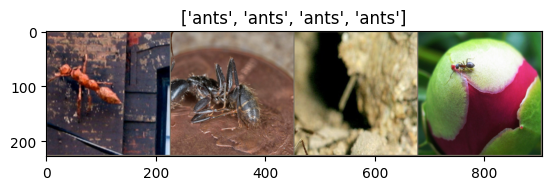

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4784 Acc: 0.7623
val Loss: 0.3007 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5316 Acc: 0.7992
val Loss: 0.6319 Acc: 0.7516

Epoch 2/24
----------
train Loss: 0.4285 Acc: 0.8115
val Loss: 0.2725 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5941 Acc: 0.7787
val Loss: 0.3889 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.4121 Acc: 0.8443
val Loss: 0.4212 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4934 Acc: 0.7992
val Loss: 0.3152 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.3860 Acc: 0.8074
val Loss: 0.2724 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3763 Acc: 0.8361
val Loss: 0.2407 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2199 Acc: 0.8852
val Loss: 0.2465 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2758 Acc: 0.8770
val Loss: 0.2668 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3727 Acc: 0.8525
val Loss: 0.2343 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3403 Acc: 0.8443
val Loss: 0.3043 Acc: 0.8889

Ep

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


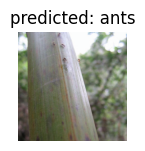

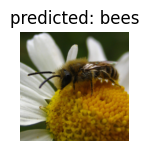

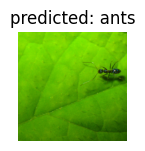

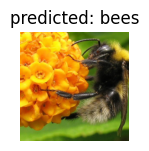

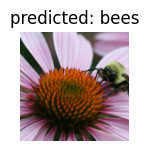

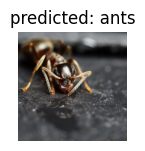

In [18]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [19]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6996 Acc: 0.6516
val Loss: 0.2014 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4233 Acc: 0.8033
val Loss: 0.2656 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4603 Acc: 0.7869
val Loss: 0.1847 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3096 Acc: 0.8566
val Loss: 0.1747 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4427 Acc: 0.8156
val Loss: 0.1630 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5505 Acc: 0.7828
val Loss: 0.1643 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3004 Acc: 0.8607
val Loss: 0.1744 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4083 Acc: 0.8361
val Loss: 0.1892 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4483 Acc: 0.7910
val Loss: 0.1984 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3335 Acc: 0.8279
val Loss: 0.1942 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2413 Acc: 0.8934
val Loss: 0.2001 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3107 Acc: 0.8689
val Loss: 0.1801 Acc: 0.9412

Ep

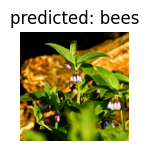

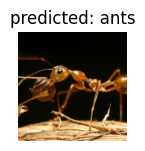

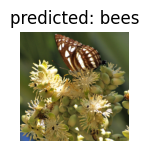

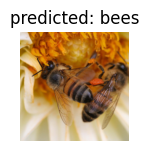

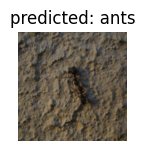

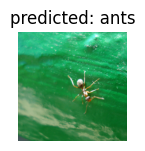

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [22]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

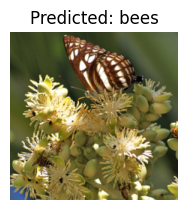

In [23]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

In [24]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# 사전 학습된 EfficientNet-B3 모델 불러오기
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model_ft = efficientnet_b3(weights=weights)

# 마지막 레이어(classifier) 수정
# EfficientNet-B3의 classifier는 [1]번 레이어에 Linear 층이 있습니다.
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2) # ants, bees 2개 클래스

model_ft = model_ft.to(device)

# 손실 함수 및 최적화 설정
criterion = nn.CrossEntropyLoss()

# 모든 파라미터를 학습시키는 최적화 설정
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에포크마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 모델 학습 시작
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 211MB/s]


Epoch 0/9
----------
train Loss: 0.6079 Acc: 0.6721
val Loss: 0.4769 Acc: 0.8693

Epoch 1/9
----------
train Loss: 0.4473 Acc: 0.8279
val Loss: 0.3545 Acc: 0.9346

Epoch 2/9
----------
train Loss: 0.4028 Acc: 0.7787
val Loss: 0.3164 Acc: 0.9085

Epoch 3/9
----------
train Loss: 0.3666 Acc: 0.8074
val Loss: 0.2843 Acc: 0.8889

Epoch 4/9
----------
train Loss: 0.3691 Acc: 0.8402
val Loss: 0.2521 Acc: 0.9216

Epoch 5/9
----------
train Loss: 0.3332 Acc: 0.8852
val Loss: 0.2296 Acc: 0.9412

Epoch 6/9
----------
train Loss: 0.3537 Acc: 0.8566
val Loss: 0.2166 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.3072 Acc: 0.8730
val Loss: 0.2664 Acc: 0.8824

Epoch 8/9
----------
train Loss: 0.3448 Acc: 0.8484
val Loss: 0.2340 Acc: 0.9150

Epoch 9/9
----------
train Loss: 0.3037 Acc: 0.8648
val Loss: 0.2306 Acc: 0.9346

Training complete in 1m 6s
Best val Acc: 0.941176


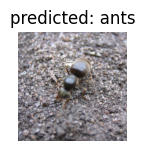

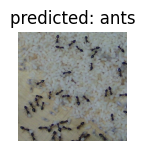

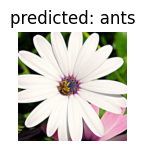

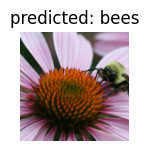

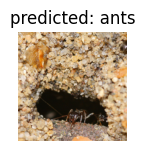

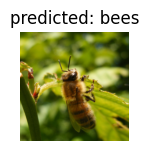

In [25]:
visualize_model(model_ft, num_images=6)

plt.ioff()
plt.show()